In [224]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.field_names import FieldName
from gluonts.mx.trainer.callback import TrainingHistory

from gluonts.time_feature import (
    day_of_week,
    day_of_month,
    day_of_year,
    week_of_year,
    month_of_year,
)

from gluonts.time_feature.holiday import (
   squared_exponential_kernel,
   SpecialDateFeatureSet,
   CHRISTMAS_DAY,
   CHRISTMAS_EVE
)

#### Read dataset

In [521]:
EVdata = pd.read_csv("stationAggDaytoDay2011_2020May12.csv", header = 0, index_col = 0)

In [522]:
EVdata = EVdata[EVdata['StartDate'] < '2020-07-01']

In [523]:
EVdata.set_index('StartDate', inplace=True)

In [524]:
EVdata.head()

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942


##### TestData: one time series

In [525]:
testData= EVdata.loc[EVdata["Station Name"] == "HAMILTON 1", ["counts", "Energy (kWh)"]]

In [526]:
testData = testData.rename(columns = {"Energy (kWh)": "target"})

In [527]:
testData["item_id"] = "HAMILTON 1"

In [528]:
testData.head()

,counts,target,item_id
StartDate,,,
2011-07-29,1,6.249457,HAMILTON 1
2011-07-30,5,28.978653,HAMILTON 1
2011-07-31,3,37.209163,HAMILTON 1
2011-08-01,1,5.041244,HAMILTON 1
2011-08-02,1,4.197217,HAMILTON 1


In [529]:
from sklearn.preprocessing import LabelEncoder

In [530]:
def one_or_multiple_time_series(data, station_name_list, target, item_id, fields):
    '''
    purpose: 
        1. select one or multiple time series
        2. change the column names

    input variables:
        data: input dataframe
        station_name_list: the station name list (each one is a time series)
        target: the target variable name
        item_id: id of each time series, here it means station name list
        fields: input fields from the input data
    '''
    testData= data.loc[EVdata["Station Name"] == station_name_list, fields]
    testData = testData.rename(columns = {target: "target"})
    testData["item_id"] = item_id
    return testData

In [531]:
def multiple_time_series(data, target, fields):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    testData = data.loc[:, fields]
    testData = testData.rename(columns = {target: "target"})
    testData['item_id'] = label_encoder.fit_transform(testData['Station Name'])
    station_name_map = testData[['Station Name', 'item_id']]
    testData.drop(columns = ['Station Name'], inplace = True)
    return testData, station_name_map

In [532]:
data = EVdata
station_name_list = "HAMILTON 1"
target = "Energy (kWh)"
item_id = "HAMILTON 1"
# fields = ["counts", "Energy (kWh)"]
fields = ["Station Name", "counts", "Energy (kWh)"]

# testData = one_or_multiple_time_series(EVdata, station_name_list, target, item_id, fields)
testData, station_name_map = multiple_time_series(EVdata, target, fields)
testData.head()


,counts,target,item_id
StartDate,,,
2011-10-13,2,8.262052,0
2011-10-14,1,6.259466,0
2011-10-15,1,4.622894,0
2011-10-17,1,4.023361,0
2011-10-18,1,15.474944,0


#### Handle missing data

In [533]:
ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = "D")

In [534]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0
print(dfs_dict)

{0:             counts    target
2011-10-13     2.0  8.262052
2011-10-14     1.0  6.259466
2011-10-15     1.0  4.622894
2011-10-16     0.0  0.000000
2011-10-17     1.0  4.023361
...            ...       ...
2020-06-26     0.0  0.000000
2020-06-27     1.0  1.133000
2020-06-28     0.0  0.000000
2020-06-29     0.0  0.000000
2020-06-30     1.0  0.969000

[3184 rows x 2 columns], 1:             counts     target
2011-10-10     2.0  16.764479
2011-10-11     1.0  13.397377
2011-10-12     2.0  16.016336
2011-10-13     1.0  18.080227
2011-10-14     1.0   5.648643
...            ...        ...
2020-06-26     0.0   0.000000
2020-06-27     0.0   0.000000
2020-06-28     0.0   0.000000
2020-06-29     0.0   0.000000
2020-06-30     0.0   0.000000

[3187 rows x 2 columns], 2:             counts     target
2016-01-14     4.0  17.080252
2016-01-15     6.0  28.369562
2016-01-16     5.0  31.712811
2016-01-17     2.0   7.865278
2016-01-18     5.0  52.964527
...            ...        ...
2020-06-26     0.0  

In [535]:
ds = PandasDataset(dfs_dict, target="target")
counts = np.array([dfs_dict[item].loc[:, "counts"].to_numpy() for item in dfs_dict])
# counts = dfs_dict["HAMILTON 1"].loc[:, "counts"].to_numpy()

/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_30027/188289404.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  counts = np.array([dfs_dict[item].loc[:, "counts"].to_numpy() for item in dfs_dict])


#### Add multiple features

##### Number of counts

In [536]:
train_val_test_split = [0.7, 0.2, 0.1]
train_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[0])
validation_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[1])
prediction_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[2])

freq = "1D"
train_start = pd.Period('2011-07-29', freq = freq)

In [537]:
train_length, validation_length, prediction_length

(2228, 636, 318)

In [538]:
next(iter(ds))["target"].shape

(3184,)

In [539]:
next(iter(ds))["target"][: -prediction_length].shape

(2866,)

##### Temporal variables

In [540]:
holidat_set = SpecialDateFeatureSet([CHRISTMAS_EVE, CHRISTMAS_DAY])

In [541]:
data.head()

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942


In [542]:
start_date = data.index.min()
end_date = data.index.max()
start_date, end_date

('2011-07-29', '2020-06-30')

In [543]:
date_indices = pd.date_range(
    start = start_date,
    end = end_date,
    freq = 'D'
)

In [544]:
day_of_week_variable = np.array([day_of_week(date_indices) for item in ds])

day_of_month_variable = np.array([day_of_month(date_indices) for item in ds])
day_year_variable = np.array([day_of_year(date_indices) for item in ds])
week_of_year_variable = np.array([week_of_year(date_indices) for item in ds])
month_of_year_variable = np.array([month_of_year(date_indices) for item in ds])

In [545]:
len(day_of_week_variable[0])

3260

In [546]:
len(day_of_week_variable[0][:train_length])

2228

#### Use train and split

In [547]:
max_length = max(len(item['target']) for item in ds)
padded_targets = [np.pad(arr['target'], (max_length - len(arr['target']), 0), mode='constant') for arr in ds]
target = np.vstack(padded_targets)
# next(iter(ds))["target"][: train_length].reshape(1, next(iter(ds))["target"][: train_length].shape[0])

In [548]:
start = np.array([item['start'] for item in ds])

In [549]:
max_length = max(len(item) for item in counts)
padded_counts = [np.pad(arr, (max_length - len(arr), 0), mode='constant') for arr in counts]
counts = np.vstack(padded_counts)

In [550]:
target

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.969],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 22.764,  9.425,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ..., 13.803, 18.608, 19.683],
       [ 0.   ,  0.   ,  0.   , ...,  5.935,  0.065, 58.624],
       [ 0.   ,  0.   ,  0.   , ...,  0.   , 27.877, 23.996]])

In [551]:
target.ndim

2

In [552]:
len(target[:, :train_length])

33

In [553]:
start_date_period = pd.Period(data.index.min(), freq='D')
start = [start_date_period for _ in range(len(target))]
start

[Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D'),
 Period('2011-07-29', 'D')]

In [554]:
freq

'1D'

In [555]:
len(target[:, :train_length][0])

2228

In [556]:
len(day_of_week_variable[:][:train_length][0])

3260

In [557]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target[:, :train_length],
            start,
            counts[:, :train_length],
            day_of_week_variable[:, :train_length],
            month_of_year_variable[:, :train_length]
        )
    ],
    freq=freq,
)

In [558]:
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target[:, :-prediction_length],
            start,
            counts[:, :-prediction_length],
            day_of_week_variable[:, :-prediction_length],
            month_of_year_variable[:, :-prediction_length]
        )
    ],
    freq=freq,
)

In [559]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            target,
            start,
            counts,
            day_of_week_variable,
            month_of_year_variable
        )
    ],
    freq=freq,
)

In [560]:
def check_train_val_test_data(train_ds, val_ds, test_ds):
    print("training data: \n \t {} \n".format(train_ds))
    print("validation data: \n \t {} \n".format(val_ds))
    print("testing data: \n \t {} \n".format(test_ds))

In [561]:
check_train_val_test_data(train_ds, val_ds, test_ds)

training data: 
 	 [{'target': array([ 0.   ,  0.   ,  0.   , ..., 23.222, 58.488, 23.058], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[0.        , 0.        , 0.        , ..., 2.        , 4.        ,
        2.        ],
       [0.16666667, 0.33333334, 0.5       , ..., 0.        , 0.16666667,
        0.33333334],
       [0.04545455, 0.04545455, 0.04545455, ..., 0.13636364, 0.22727273,
        0.22727273]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ..., 28.246, 25.99 ,  2.288], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[0.        , 0.        , 0.        , ..., 3.        , 4.        ,
        1.        ],
       [0.16666667, 0.33333334, 0.5       , ..., 0.        , 0.16666667,
        0.33333334],
       [0.04545455, 0.04545455, 0.04545455, ..., 0.13636364, 0.22727273,
        0.22727273]], dtype=float32)}, {'target': array([ 0.   ,  0.   ,  0.   , ..., 24.135, 33.996,  9.856], dtype=float32), 's

#### Visualize the dataset

In [562]:
def visualize_train_val_test_data(train_ds, val_ds, test_ds):
    train_entry = next(iter(train_ds))
    train_series = to_pandas(train_entry)
    
    val_entry = next(iter(val_ds))
    val_series = to_pandas(val_entry)

    test_entry = next(iter(test_ds))
    test_series = to_pandas(test_entry)

    plt.figure(figsize=(10, 6))
    
    test_series.plot(color = "grey")
    plt.axvline(train_series.index[-1], color="red")  # end of train dataset
    plt.axvline(val_series.index[-1], color="blue")  # end of train dataset
    plt.grid(which="both")
    plt.legend(["test series", "end of train series", "end of val series"], loc="upper left")
    plt.show()

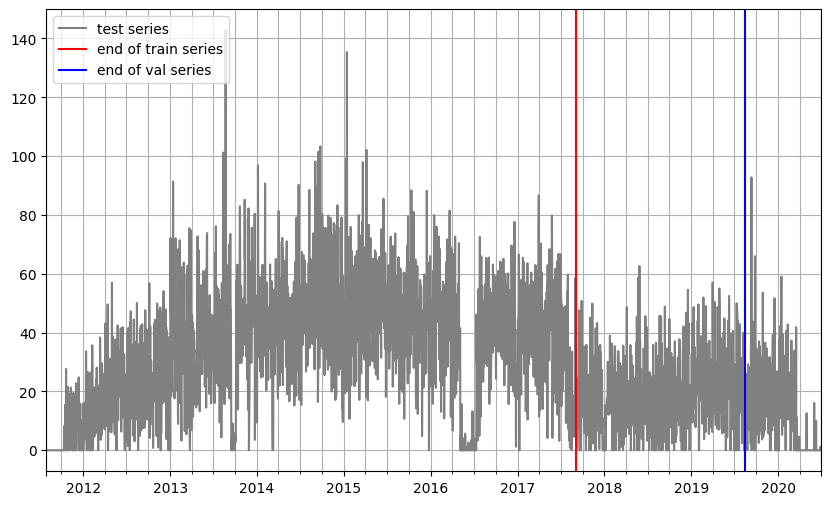

In [563]:
visualize_train_val_test_data(train_ds, val_ds, test_ds)

#### Train and prediction

##### Simple feed forward estimator

In [564]:
# defining a callback, which will log the training loss for each epoch
history = TrainingHistory()

In [565]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### MQCNN estimator

In [566]:
from gluonts.mx import MQCNNEstimator, Trainer

In [567]:
mqcnn_estimator = MQCNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### MQRNN estimator

In [568]:
from gluonts.mx import MQRNNEstimator, Trainer

In [569]:
mqrnn_estimator = MQRNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### DeepAR estimator

In [570]:
from gluonts.mx import DeepAREstimator, Trainer

In [613]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [572]:
from gluonts.mx import DeepVAREstimator, Trainer

In [573]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    target_dim= 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### LSTNet

In [574]:
from gluonts.mx import LSTNetEstimator, Trainer

In [575]:
lstnet_estimator = LSTNetEstimator(
    num_series = 1,
    prediction_length = prediction_length,
    ar_window = 10,
    channels = 1,
    context_length = 20,
    skip_size = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [576]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [577]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 10,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [578]:
from gluonts.mx import TransformerEstimator, Trainer

In [579]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    context_length = 100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [580]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [581]:
deepFactor_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [582]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [583]:
gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Naive predictor

In [584]:
from gluonts.ext.naive_2 import Naive2Predictor

In [585]:
naive_predictor = Naive2Predictor(
    prediction_length = prediction_length,
    season_length = 100
)

##### Train and predict

In [586]:
def train_and_predict(train_dataset, val_dataset, test_dataset, estimator):
    predictor = estimator.train(training_data = train_dataset, validation_data = val_dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return predictor, list(forecast_it), list(ts_it)


In [587]:
def get_model_name(estimator):
    s = str(estimator)

    start_marker = ".model."
    end_marker = "._estimator"

    start_index = s.find(start_marker)
    if(start_index == -1):
        raise ValueError("Couldn't find start index!")

    end_index = s.find(end_marker, start_index)
    if(end_index == -1):
        return ValueError("Couldn't find end index!")
    
    start_index += len(start_marker)
    return s[start_index: end_index]

In [598]:
def multiple_models(train_ds, val_ds, test_ds, estimators):
    for estimator in estimators:
        
        ## model training
        predictor, forecast_it, ts_it = train_and_predict(train_ds, val_ds, test_ds, estimator)

        ## loss curve
        loss_data_framework = get_loss_curve(history)
        print("loss curve")
        print(loss_data_framework)
        export_loss_curve(loss_data_framework, estimator)
        plot_loss_curve(loss_data_framework)

        ## evluation metrics
        print_forecast_basic_info(forecast_it, ts_it)
        export_original_time_series_no_missing_values(ts_it)
        export_predicted_values(ts_it, forecast_it, estimator)
        plot_orginal_prediction(forecast_it, ts_it, estimator)
        agg_metrics, item_metrics = get_evaluation_metrics(forecast_it, ts_it)
        export_eval_metrics(agg_metrics, item_metrics, estimator)

        return predictor, agg_metrics, item_metrics, forecast_it, ts_it
    

In [599]:
def get_loss_curve(history):
    loss_data_framework = pd.DataFrame({
        "training_loss": history.loss_history,
        "val_loss": history.validation_loss_history
    })
    loss_data_framework.head()
    return loss_data_framework

In [600]:
def export_loss_curve(loss_data_framework, estimator):
    loss_curve_name = "loss_curve_model_{}.csv".format(get_model_name(estimator))
    loss_data_framework.to_csv(loss_curve_name)

In [601]:
def plot_loss_curve(loss_data_framework):
    # Clear the current figure
    plt.clf()
    
    loss_data_framework.plot()

In [602]:
def print_forecast_basic_info(forecast_it, ts_it):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]

    print(f"Number of sample paths: {forecast_entry.num_samples}")
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

In [603]:
def export_original_time_series_no_missing_values(ts_it):

    ts_entry = ts_it[0]
    
    time_series_original = pd.DataFrame(ts_entry)
    time_series_original.columns = ['true_value']
    time_series_original.to_csv("time_series_original_no_missing_values.csv")

In [604]:
def export_predicted_values(ts_it, forecast_it, estimator):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]
    
    predicted_values = "predicted_values_model_{}.csv".format(get_model_name(estimator))
    predicted_values_100_series = pd.DataFrame(forecast_entry.samples.T)
    predicted_values_100_series.to_csv(predicted_values)

In [605]:
def plot_orginal_prediction(forecast_it, ts_it, estimator):
    # Clear the current figure
    plt.figure(figsize=[10, 6])
    
    samples = [0, 10, 20, 30]
    for i in samples:
        plt.clf()
        forecast_entry = forecast_it[i]
        ts_entry = ts_it[i]

        plt.plot(ts_entry[-800:].to_timestamp())
        forecast_entry.plot(show_label=True)
        plt.legend()
        plt.savefig("testing_{}{}.png".format(get_model_name(estimator), i))

In [606]:
def get_evaluation_metrics(forecast_it, ts_it):

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it)

    return agg_metrics, item_metrics

In [607]:
def export_eval_metrics(agg_metrics, item_metrics, estimator):
    ## agg_metrics
    print("Evaluation metrics: {}".format(get_model_name(estimator)))
    agg_metrics_data_frame = pd.DataFrame([agg_metrics])

    agg_metrics_csv_name = "agg_metrics_{}.csv".format(get_model_name(estimator))

    item_metrics_csv_name = "item_metrics_{}.csv".format(get_model_name(estimator))

    agg_metrics_data_frame.to_csv(agg_metrics_csv_name)
    item_metrics.to_csv(item_metrics_csv_name)

In [614]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstNetEstimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN

# estimators = [simple_feed_forward_estimator, \
#               deepAR_estimator, \
#               deepVAR_estimator, \
#               lstNetEstimator, \
#               transformer_estimator, \
#               mqcnn_estimator]

estimators = [deepAR_estimator]

predictor, agg_metrics, item_metrics, forecast_it, ts_it = multiple_models(train_ds, val_ds, test_ds, estimators)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:24<00:00,  1.18it/s, epoch=1/8, avg_epoch_loss=1.63]
2it [00:02,  1.11s/it, epoch=1/8, validation_avg_epoch_loss=3.89]
100%|██████████| 100/100 [01:41<00:00,  1.02s/it, epoch=2/8, avg_epoch_loss=0.996]
2it [00:00,  3.80it/s, epoch=2/8, validation_avg_epoch_loss=3.89]
 79%|███████▉  | 79/100 [01:02<00:16,  1.28it/s, epoch=3/8, avg_epoch_loss=0.649]

In [612]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2019-08-18,146.132690,2303.453857,4124.133789,12.968974,14.040041,0.515922,0.477891,1.139149,0.558530,9.095147,648.755933,0.009434,2303.453898,0.191824,2654.593354,0.503145
1,None,2019-08-18,173.343627,2555.363525,4754.918945,14.952575,14.581586,0.551088,1.070349,1.069597,0.537415,9.301360,733.554377,0.018868,2555.363505,0.204403,2852.565322,0.477987
2,None,2019-08-18,155.034444,2271.840576,3861.621094,12.143463,6.101396,1.170905,2.775220,1.167938,0.588313,21.370882,654.166961,0.040881,2271.840684,0.248428,2555.538639,0.500000
3,None,2019-08-18,310.591293,3674.274170,7552.945801,23.751402,5.364014,2.154044,0.470171,1.001193,0.486469,29.212714,1097.803896,0.009434,3674.273913,0.169811,3803.637958,0.449686
4,None,2019-08-18,320.537859,3786.974121,10084.562500,31.712461,5.642529,2.110529,0.363338,0.812715,0.375522,20.231259,1249.413076,0.028302,3786.974100,0.251572,3171.878229,0.572327
5,None,2019-08-18,402.027712,4176.145996,11041.775391,34.722564,5.871519,2.236650,0.498811,0.798142,0.378213,28.746508,1369.377499,0.047170,4176.146127,0.210692,3876.161772,0.584906
6,None,2019-08-18,191.076209,3175.376465,10041.070312,31.575693,8.419219,1.186032,0.574147,0.515543,0.316239,9.603401,1293.146528,0.157233,3175.376537,0.550314,1869.904289,0.839623
7,None,2019-08-18,167.377752,2835.804199,6853.974609,21.553379,7.858865,1.134722,1.458524,0.774082,0.413746,12.011683,907.740960,0.078616,2835.803937,0.455975,2205.380848,0.704403
8,None,2019-08-18,248.785623,3443.922852,10540.249023,33.145437,3.024864,3.580309,0.469579,0.528356,0.326740,34.161868,1247.089146,0.094340,3443.923005,0.433962,2450.153823,0.783019
9,None,2019-08-18,296.354019,3626.241211,8699.489258,27.356884,2.951149,3.864012,0.442119,0.827026,0.416834,45.433296,1140.892042,0.037736,3626.241347,0.336478,3326.499400,0.660377


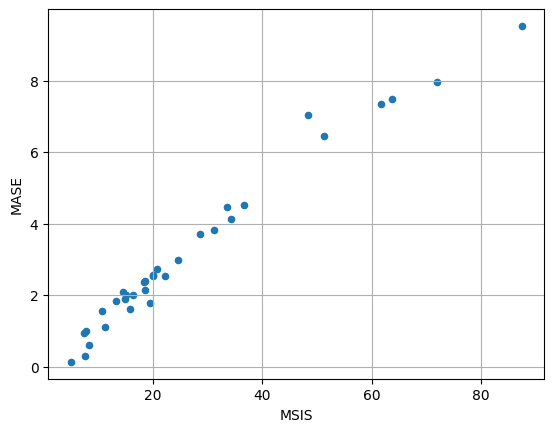

In [610]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

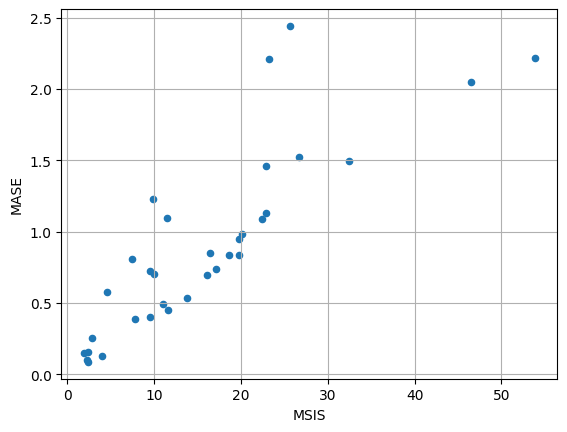

In [311]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

#### Save existing model

In [74]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

#### Write a document here

In [316]:
#### Feed forward neural network
#### LSTM
#### DeepAR
#### Tranformer

#### Metrics